## Still needs to be done:
- fix the confidence analysis by multiplying the probs of Dc_within and _between 
- slope erosional map
- implement interactive plots in plotly?
- draw inputs from a txt file?

### Import libraries

In [1]:
import numpy as np                  # library for arrays 
import pandas as pd                 # library for tables 
import geopandas as gpd             # library for georeferenced tables 
import matplotlib.pyplot as plt     # plotting library
import matplotlib.gridspec as gs    # library to make gridded subplots
from matplotlib.pyplot import cm    # colour management liibrary
import seaborn as sns               # pretty statistical plotting library
import scipy.interpolate as intr    # interpolation functions
import utm                          # conversion from and to UTM coordinates
from os import mkdir, path          # operating system utilities

# this command displays plots below the related cell
%matplotlib inline

# Alternatively, this command makes matplotlib open an interactive window everytime a figure is produced
# %matplotlib notebook 

sns.set(style='white', context='talk') # all plots have white background and large fontsize

### Specify input files and parameters

In [2]:
# Input rasters as ASCII files, with .txt or .asc extension
# Best resampled to a reasonably low resolution before importing it.
# If not, no big deal, but computational time increases
# Input Coordinate Reference System must be WGS1984
dem_filename = 'dem.txt' # digital elevation model
e_map_filenames = ['e_map0.asc','e_map0.asc'] # list of erosion maps with same extent as DEM, each cell has an erosional weigth

# watershed shapefile filename with .shp extension
ws_filename = 'ws_lc.shp'

# Input bedrock and detrital ages filenames, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd
bedrock_ages_filename = 'bedrock_data.xlsx'
detrital_ages_filename = 'detrital_data.xlsx'

# Input target resolution of the interpolated surface [meters]
res = 500 

# do you want to use Radial Basis Function (RBF)?
# This function uses a linear radial basis function --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
# to interpolate also beyond the area covered by the samples
rbf_method = 'yes' # 'yes' or 'no'

# If no RBF is used, griddata interpolation is used --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
# which stops within the edges of the input datapoints.
# Would you want to additionally extrapolate ages outside of the data points?
extra = 'no' # 'yes' or 'no'

# If yes, an inverse-distance-weighted average is used to assign a value
# to the cells out of the linear interpolation field, but not farther than the search radius 'extra_rad'
# which search radius do you want?
extra_rad = 2000 # meters

# How do you want to name the output folder for this simulation?
opf = 'output'

### Import input files and display them

In [3]:
########################## Open DEM and read the metadata ################################
##########################################################################################

def read_ascii(filename, verbose=True):
    '''
    Function to read an ASCII raster, most commonly exported from ArcGIS or QGIS.
    The first 6 lines must inform:
    
    ncols
    nrows
    xllcorner  
    yllcorner  
    cellsize   
    NODATA_value
    
    followed by the raster values separated by spaces
    
    if verbose=False, metadata is not printed, but only returned
    '''
    
    # read DEM text file
    fid = open('input/'+filename, 'r')

    # make a table of the dem info and convert values tosuitable data types (integer, float)
    dem_info = [fid.readline().split() for i in range(6)]
    dem_info = np.array(dem_info).transpose()
    dem_info = dict([(k,v) for k,v in zip(dem_info[0],dem_info[1])])
    dtypes = (int,int,float,float,float,float)
    for i,f in zip(dem_info,dtypes):
        dem_info[i]=f(dem_info[i])

    # get the dem data as a list of strings
    dem_ls_of_str = [fid.readline().split() for i in range(dem_info['nrows'])]
    
    # then convert all strings to floats
    dem = np.array([[float(i) for i in dem_ls_of_str[j]] for j in range(dem_info['nrows'])])
    if dem.shape != (dem_info['nrows'], dem_info['ncols']):
        print('something went wrong while parsing the DEM, nrows and/or ncols do not match the original input')
    
    # change NODATA_value to np.nan
    dem[dem==dem_info['NODATA_value']]=np.nan

    if verbose == True:
        # Print details of imported DEM, except nodata value
        print('')
        print('METADATA OF '+filename)
        print('')
        for k,v in dem_info.items():
            if k != 'NODATA_value':
                print(k+' = '+str(v))
                print('')
        print('Initial cellsize in meters = ~{}'.format(int(np.around(dem_info['cellsize']*110000,1)/10)*10))
        print('')
        print('min value = '+str(np.nanmin(dem)))
        print('')
        print('max value = '+str(np.nanmax(dem)))
        print('')
    return dem, dem_info

dem, dem_info = read_ascii(dem_filename)
e_maps = {}
e_maps_info = {}
count=0
for i in e_map_filenames:
    count+=1
    key = 'E_map'+str(count)
    e_maps[key], e_maps_info[key] = read_ascii(i)

max_e = max([np.nanmax(m) for k,m in e_maps.items()])


METADATA OF dem.txt

ncols = 241

nrows = 121

xllcorner = -71.200416424533

yllcorner = -33.000416206563

cellsize = 0.000833333333

Initial cellsize in meters = ~90

min value = 137.0

max value = 2218.0


METADATA OF e_map0.asc

ncols = 241

nrows = 121

xllcorner = -71.200416424533

yllcorner = -33.000416206563

cellsize = 0.000833333333

Initial cellsize in meters = ~90

min value = 0.0

max value = 100.0


METADATA OF e_map0.asc

ncols = 241

nrows = 121

xllcorner = -71.200416424533

yllcorner = -33.000416206563

cellsize = 0.000833333333

Initial cellsize in meters = ~90

min value = 0.0

max value = 100.0



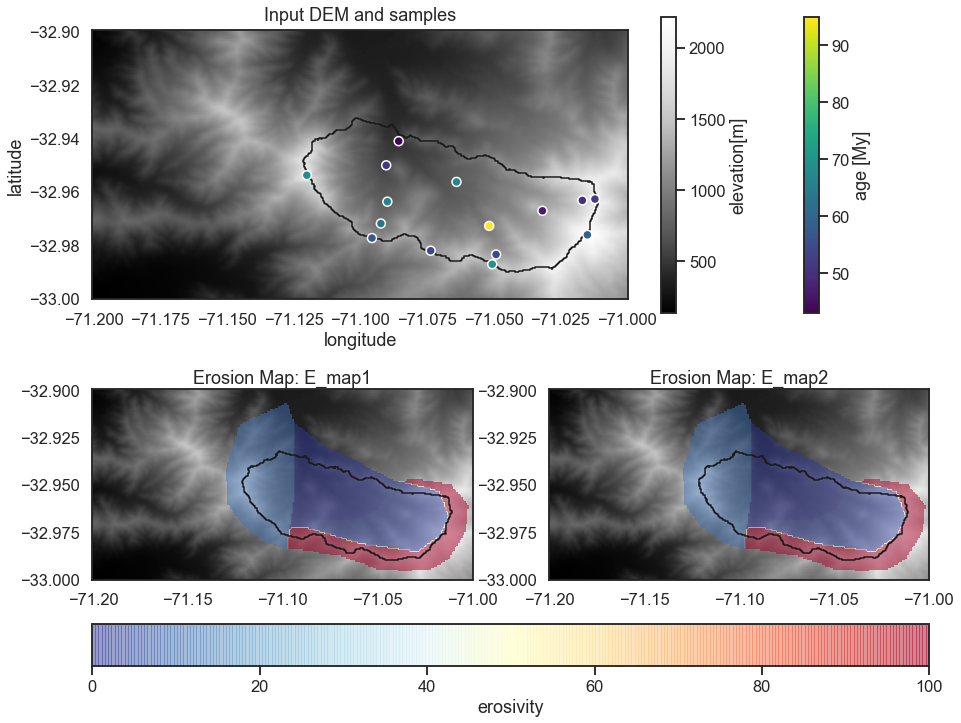

In [4]:
################# Now import age dataset into a pd.DataFrame ##############################
##########################################################################################

bd = pd.read_excel('input/'+bedrock_ages_filename)

z = bd.elev.values
if z.mean()<10:
    z = z*1000 # convert elevations from km to meters, if that's the case
a = bd.age.values
u = bd.sd.values
lat = bd.lat.values
lon = bd.lon.values

# convert from geographic to projected coordinates,
# otherwise the interpolation will overestimate the role of elevation and produce funny results.
# preallocate arrays
x_utm = np.array([])
y_utm = np.array([])
for i,v in enumerate(lat):
    xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=19
    x_utm = np.append(x_utm, xy_utm[0])
    y_utm = np.append(y_utm, xy_utm[1])

# add points at -5000 m below sample elevation (zero cooling age depth) to arrays
# such that each x,y location has a double with age=0 and elev=z-5000
xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy...)
yy_utm = y_utm
zz = z
aa = a
for i,v in enumerate(z):
    xx_utm = np.append(xx_utm, x_utm[i])
    yy_utm = np.append(yy_utm, y_utm[i])
    zz = np.append(zz, v-5000)
    aa = np.append(aa, 1e-9)
    
################# Now import watershed outline as geopandas.DataFrame ##############################
##########################################################################################

ws_outline = gpd.read_file('input/'+ws_filename)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# specify the figure's geographical extent in lat,lon
extent84 = (dem_info['xllcorner'],
            dem_info['xllcorner']+dem_info['ncols']*dem_info['cellsize'],
            dem_info['yllcorner'],
            dem_info['yllcorner']+dem_info['nrows']*dem_info['cellsize'])

# make figure, gridspec and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit 
fig = plt.figure(figsize=(15,12))
gspec = gs.GridSpec(2,len(e_maps.keys()),figure=fig)

# raster plot
ax1 = fig.add_subplot(gspec[0,:]) # first row of plot
im = ax1.imshow(dem, origin='upper', cmap='Greys_r', extent=extent84)
# polygon plot
poly = ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
# scatter plot
sct = ax1.scatter(lon, lat, c=a, cmap='viridis', edgecolor='w')
ax1.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax1.set_title('Input DEM and samples',pad=10)
# colorbar
cb2 = fig.colorbar(sct)
cb2.set_label('age [My]')
cb1 = fig.colorbar(im)
cb1.set_label('elevation[m]')

# plot imported erosional maps
count = 0
row2 = []
for k,i in e_maps.items():
    count+=1
    ax = fig.add_subplot(gspec[1,count-1])
    row2.append(ax)
    im2= ax.imshow(dem, origin='upper', cmap='Greys_r', extent=extent84)
    em = ax.imshow(i, origin='upper', cmap='RdYlBu_r', extent=extent84, alpha=0.5, vmin=0, vmax=max_e)
    ws_outline.plot(edgecolor='k',facecolor='None',ax=ax)
    ax.set(title='Erosion Map: '+k)
    if count == gspec.get_geometry()[1]:
        cb3 = fig.colorbar(em,orientation='horizontal',ax=row2)
        cb3.set_label('erosivity')

# make output directory
if not path.exists(opf):
    mkdir(opf)

# and save figure
fig.savefig(opf+'/input_data.pdf', dpi=200)

### Resample DEM and interpolate ages to that topographic surface

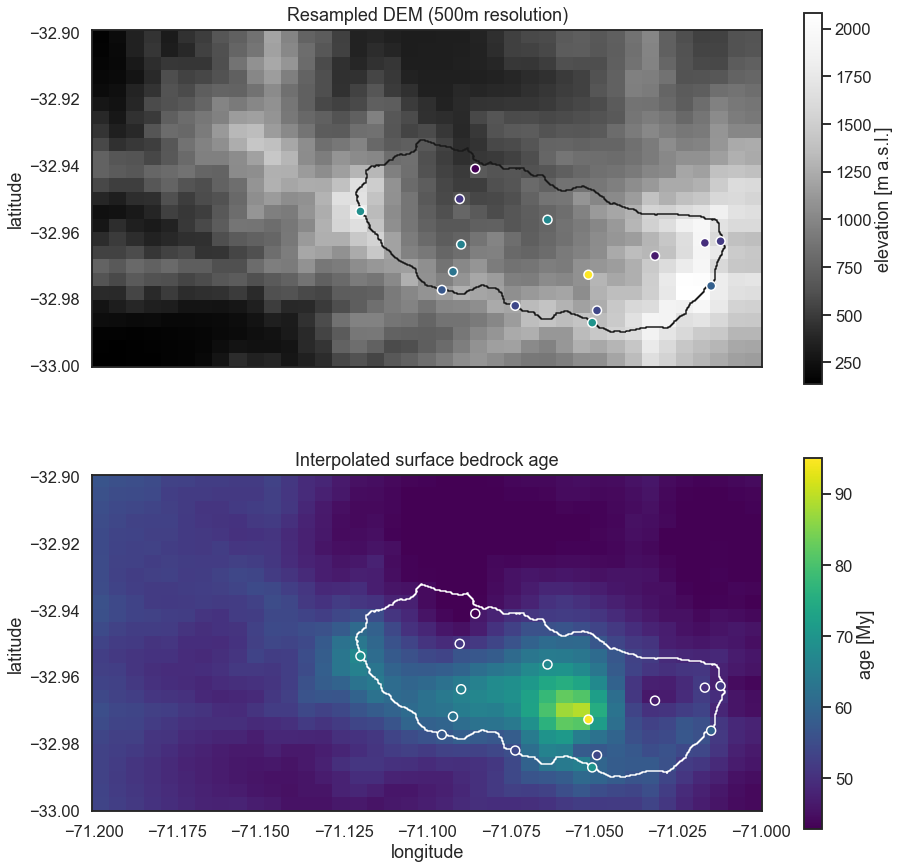

In [5]:
############################ First make all the coordinate grids #################################
##################################################################################################

# convert llcorner and urcorner coordinates to utm and define extentUTM
xyll = utm.from_latlon(extent84[2], extent84[0]) #force_zone_number=19
xyur = utm.from_latlon(extent84[3], extent84[1]) #force_zone_number=19
extentUTM = (xyll[0], xyur[0], xyll[1], xyur[1])

# make high resolution easting and northing vectors, to be resampled
Xi = np.linspace(xyll[0], xyur[0], dem_info['ncols'])
Yi = np.linspace(xyll[1], xyur[1], dem_info['nrows'])
xi, yi = np.meshgrid(Xi,Yi)
yi = yi[::-1] ################ flipped row order for latitude to decrease from top
# 1d vectors, needed for linear interpolation
xi_1d = xi.reshape(xi.size)
yi_1d = yi.reshape(yi.size)
zi_1d = dem.reshape(dem.size)

# make lower resolution easting and northing vectors
Xi_res = np.arange(xyll[0], xyur[0]+res, res)
Yi_res = np.arange(xyll[1], xyur[1]+res, res)
xi_res, yi_res = np.meshgrid(Xi_res, Yi_res)
yi_res = yi_res[::-1] ###################### flipped row order for latitude to decrease from top
xi_res_1d = xi_res.reshape(xi_res.size)
yi_res_1d = yi_res.reshape(yi_res.size)

# make lon-lat vectors at same resolution, (needed later on?)
Xi_res84 = np.linspace(extent84[0], extent84[1], xi_res.shape[1])
Yi_res84 = np.linspace(extent84[2], extent84[3], xi_res.shape[0])
xi_res84, yi_res84 = np.meshgrid(Xi_res84,Yi_res84)

################## Resample rasters (nearest neighbour) at new grid nodes ############################
###################################################################################################

def resample_raster(zi_1d, xi_1d, yi_1d, xi_res_1d, yi_res_1d, method='nearest', output_1d=True):
    '''
    Function to resample the input rasters to desired resolution.
    By default it uses a nearest neighbor algorithm
    zi_1d = 1d-array of input z-values
    xi_1d = 1d-array of input x coordinates
    yi_1d = 1d-array of input y coordinates
    xi_res_1d = 1d-array of target x coordinates
    yi_res_1d = 1d-array of target y coordinates
    method --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
    output_1d, if True outputs resampled points as both 1d- and 2d-arrays respectively
    
    '''
    # resample by interpolating at larger steps (specified as "res")
    # input_coords are organized in a 2D array, with columns representing x,y
    input_coords = np.concatenate(([xi_1d],[yi_1d])).transpose()

    # resampled coords are organized in a 2D array, with columns representing x,y
    res_coords = np.concatenate(([xi_res_1d],[yi_res_1d])).transpose()

    # Now resample: the 'values' variable refers to the known elevations of the input dem
    zi_res_1d = intr.griddata(points=input_coords, values=zi_1d, xi=res_coords, method='nearest')
    zi_res = zi_res_1d.reshape(xi_res.shape) # reshape from 1D to 2D
    
    if output_1d == True:
        return zi_res_1d, zi_res
    else:
        return zi_res
    

zi_res_1d, zi_res = resample_raster(zi_1d, xi_1d, yi_1d, xi_res_1d, yi_res_1d)
e_maps_res = dict()
for k,i in e_maps.items():
    e_maps_res[k] = resample_raster(i.reshape(dem.size), xi_1d, yi_1d, xi_res_1d, yi_res_1d, output_1d=False)

########################## Interpolate age data onto the topographic surface #######################
####################################################################################################

# known data points, for which the interpolation function is found
# they are organized in a 2D array, with columns representing x,y,z
pts = np.concatenate(([xx_utm],[yy_utm],[zz])).transpose()

# positions where interpolation needs to be made (all the catchment's gridcells)
# they are organized in a 2D array, with columns representing x,y,z
pos = np.concatenate(([xi_res_1d],[yi_res_1d],[zi_res_1d])).transpose()

# Now run the interpolation.
# with either Radial Basis Functions
if rbf_method == 'yes':
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(xi_res, yi_res, zi_res)
    age_interp = age_interp_map.reshape(age_interp_map.size)
    
# or with griddata interpolation
elif rbf_method == 'no':
    # the 'values' variable refers to the known ages of the data points
    age_interp = intr.griddata(points=pts, values=aa, xi=pos)
    age_interp_map = age_interp.reshape(zi_res.shape)

    
######################### If desired, extrapolate points at the edges ############################
####################### Using an inverse-distance-weighted function ####################
###################################################################################################

def extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, extra_rad, gdop2D):
    '''
    Extrapolates data within wanted radius
    using an inverse distance weighted average of the available data points
    input arguments:
    gdop: griddata output,
          a 1D-array that contains the interpolated data
          as well as the nans that you want to replace
          
    '''

    # select only nans out of the griddata output 
    nans = gdop[gdop!=gdop]
    nansx = gdopx[gdop!=gdop]
    nansy = gdopy[gdop!=gdop]
    nansz = gdopz[gdop!=gdop]

    # define distance function
    def dist3D(xyz1, xyz2):
        '''
        Calculates the distance between two points in 3D.
        xyz1 - list or tuple of x,y,z coords for first point
        xyz2 - list or tuple of x,y,z coords for second point
        '''
        return np.sqrt((xyz1[0]-xyz2[0])**2+(xyz1[1]-xyz2[1])**2+(xyz1[2]-xyz2[2])**2)

    # This is the workflow of the extrapolation function:
    # for each of the nans:
    # calculate inverse distance from NaN to all samples, drop samples too far away
    # multiply inverse distances by related age and store in a [1 x M] vector of weighted values
    # summate and divide by M

    for i in np.arange(nans.size):
        # make array of ages divided by distance and number of data points
        dists = np.array([dist3D((nansx[i],nansy[i],nansz[i]),(datax[j],datay[j],dataz[j])) for j in np.arange(data.size)])
        dists1 = dists[dists < extra_rad] # do not consider points farther than extra_rad
        data1 = data[dists < extra_rad] # select related ages 
        dists1 = 1/dists1 # invert distances
        weighted_ages = np.array([dists1[k]*data1[k] for k in np.arange(data1.size)])
        nans[i] = weighted_ages.sum()/dists1.sum() # compute weighted average
        # should add a way to extrapolate to different elevations than the closest points

    # now substitute nans with extrapolated values
    gdop[gdop!=gdop] = nans
    return gdop.reshape(gdop2D.shape)

if extra == 'yes':
    #assign arguments
    gdop = age_interp.copy() # GridData OutPut
    gdopx = xi_res_1d # array of griddata output x coordinates
    gdopy = yi_res_1d # array of griddata output y coordinates
    gdopz = zi_res_1d # array of griddata output z coordinates

    data = a # data points values to interpolate
    datax = x_utm # data points x coord
    datay = y_utm # data points y coord
    dataz = z # data points z coord

    gdop2D = zi_res # 2D grid related to gdop, needed to reshape final output to correct gridsize
    
    # call the function
    extra_grid = extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, extra_rad, gdop2D)

#################################### And plot it ##################################################
###################################################################################################
  
fig = plt.figure(figsize=(15,15))
gspec = gs.GridSpec(2,1,figure=fig)

ax1 = fig.add_subplot(gspec[0])

im1 = ax1.imshow(zi_res, origin='upper', extent=extent84, cmap='Greys_r')
ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
ax1.set(aspect='equal', ylabel='latitude', xticks=[])
ax1.set_title('Resampled DEM ('+str(res)+'m resolution)', pad=10)
cb = fig.colorbar(im1)
cb.set_label('elevation [m a.s.l.]')


ax2 = fig.add_subplot(gspec[1])

if extra == 'yes':
    # plot bedrock surface age map including extrapolation
    im2 = ax2.imshow(extra_grid, origin='upper', extent=extentUTM, cmap='viridis',
                     vmin=a.min(), vmax=a.max(), alpha=1)
else:
    # plot bedrock surface age map
    im2 = ax2.imshow(age_interp_map, origin='upper', extent=extent84, cmap='viridis',
                     vmin=a.min(), vmax=a.max(), alpha=1)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax2)
ax2.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax2.set_title('Interpolated surface bedrock age', pad=10)
cb = fig.colorbar(im2)
cb.set_label('age [My]')


# plot samples and ages
for ax in [ax1,ax2]:
    ax.scatter(x=lon, y=lat, c=a, cmap='viridis', vmin=a.min(), vmax=a.max(), edgecolor='w')
    
# save fig
fig.savefig(opf+'/DEMres'+str(res)+'_ageinterp.pdf', dpi=200)

### Produce error map through bootstrapping

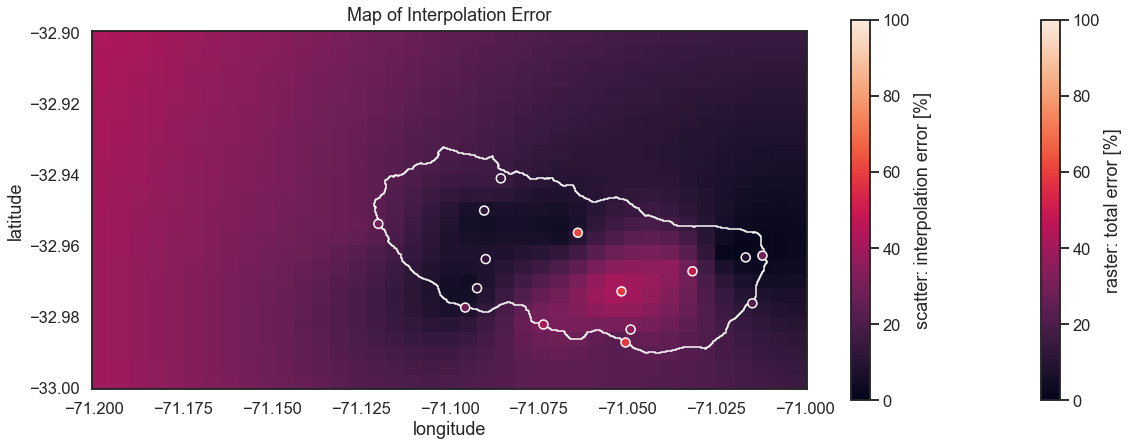

In [6]:
# pre-allocate a vector with as many elements as bedrock samples
error_interp = np.zeros(lat.size)

# Bootstrap:
# for each bedrock sample
# 1. exclude the related point from input data
# 2. calculate an interpolated surface age at its location
# 3. save the difference to the known measured age.
for i in np.arange(lat.size):
    a_boot = np.delete(aa, i)
    x_boot = np.delete(xx_utm, i)
    y_boot = np.delete(yy_utm, i)
    z_boot = np.delete(zz, i)
    
    # either use Radial Basis Function interpolation
    if rbf_method == 'yes':
        rbfi = intr.Rbf(x_boot, y_boot, z_boot, a_boot, function='linear')
        a_int = rbfi(xx_utm[i], yy_utm[i], zz[i]) # get interpolated age of excluded sample
        
    # or griddata interpolation
    else:
        pts1 = np.concatenate(([x_boot],[y_boot],[z_boot])).transpose() # data without i sample
        pos1 = np.concatenate(([xx_utm[i]], [yy_utm[i]], [zz[i]])) # coordinates of i sample
        a_int = intr.griddata(points=pts1, values=a_boot, xi=pos1)[0]
    
    error_interp[i] = abs(aa[i]-a_int)/aa[i]*100
    
# calculate sqrt of the square error_interp + square age_sd
error_total = np.sqrt(error_interp**2+(u/a*100)**2)
# substitute nans at edge of interpolation with mean error
error_total[error_total!=error_total] = np.nanmean(error_total)

##################################### Now make the map ################################
###################################################################################
# with RBF if specified
if rbf_method == 'yes':
    rbfi = intr.Rbf(x_utm, y_utm, error_interp, function='linear') # not considering elevation here
    age_interp_error_map = rbfi(xi_res, yi_res) # get interpolated age of excluded sample
    

# or with Griddata interpolation
else:
    pts_err = np.concatenate(([x_utm],[y_utm])).transpose()
    age_interp_error = intr.griddata(points=pts_err, values=error_total, xi=res_coords)

    # preallocate array
    age_interp_error_map = np.ones(zi_res.shape)

    for i in np.arange(age_interp_error.size):
        x_ind = int(np.rint((xi_res_1d[i]-xyll[0])/res))
        y_ind = int(np.rint((yi_res_1d[i]-xyll[1])/res))

        # assign nan if out of the catchment bounds
        if zi_res[y_ind][x_ind] != zi_res[y_ind][x_ind]:
            age_interp_error_map[y_ind][x_ind] = np.nan

        else:
            age_interp_error_map[y_ind][x_ind] = age_interp_error[i]

    age_interp_error_map = age_interp_error_map[::-1] # flipped to have correct latitude

# extrapolate if required
if extra == 'yes':
    #assign arguments
    gdop = age_interp_error_map.reshape(age_interp_error_map.size) # GridData OutPut in 1D
    gdopx = xi_res_1d # array of griddata output x coordinates
    gdopy = yi_res_1d # array of griddata output y coordinates
    gdopz = zi_res_1d # array of griddata output z coordinates

    data = error_total # data points values to interpolate
    datax = x_utm # data points x coord
    datay = y_utm # data points y coord
    dataz = z # data points z coord

    gdop2D = zi_res # 2D grid related to gdop, needed to reshape final output to correct gridsize
    
    # call the function
    extra_errormap = extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, extra_rad, gdop2D)

##################################### Plot the error map ################################
#########################################################################################

fig,ax = plt.subplots(1,1,figsize=(20,7))

if extra == 'yes':
    # plot error map including extrapolation
    im = ax.imshow(extra_errormap, origin='upper', extent=extent84, vmin=0, vmax=100, alpha=1)
else:
    # plot error map
    im = ax.imshow(age_interp_error_map, origin='upper', extent=extent84, vmin=0, vmax=100)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
sct = ax.scatter(x=lon, y=lat, c=error_total, edgecolor='w', vmin=0, vmax=100)

ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Map of Interpolation Error', pad=10)
cb = fig.colorbar(im)
cb1 = fig.colorbar(sct)
cb.set_label('raster: total error [%]')
cb1.set_label('scatter: interpolation error [%]')

# save fig
fig.savefig(opf+'/age_interp_error_map.pdf', dpi=200)

## Clip to watershed 

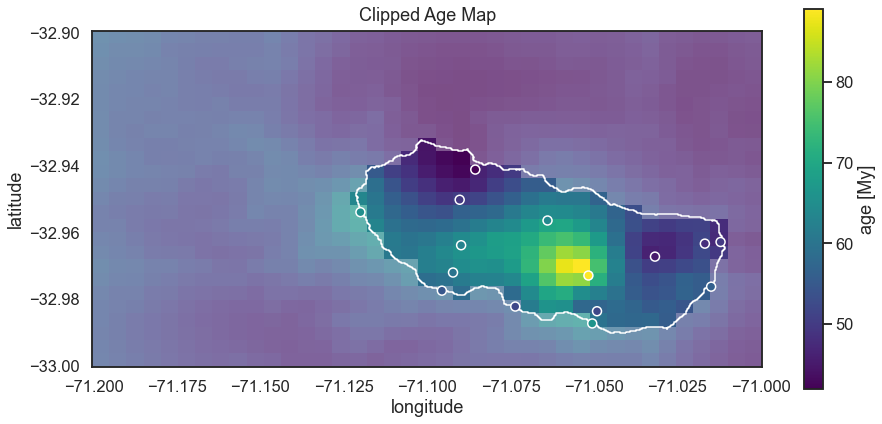

In [7]:
def clip_to_ws(raster, shp_filename, extent):
    '''
    This function clips the input raster to the watershed shapefile,
    so that all raster cells can be used to predict detrital distributions
    - raster: 2D np.array
    - shp_filename: string, filename of the watershed shapefile
    - extent: tuple or list, extent of the raster in wgs1984 (west, east, south, north)
    '''
    import fiona
    import rasterio
    from rasterio.plot import show
    from rasterio.mask import mask
    from shapely.geometry import Polygon
    
    # calculate x and y cellsize in degrees
    xsize = np.abs(extent[0]-extent[1])/raster.shape[1]
    ysize = np.abs(extent[2]-extent[3])/raster.shape[0]
    # define rasterio transform function
    transform = rasterio.transform.from_origin(extent[0], extent[3], xsize, ysize)
    # define coordinate reference system to wgs1984
    crs = rasterio.crs.CRS.from_epsg(4326) # wgs1984: 4326
    # make new raster file based on input, necessary step to use rasterio's functions,
    # and define the metadata
    src = rasterio.open('output/raster.tif', 'w', driver='GTiff',
                        height = raster.shape[0], width = raster.shape[1],
                        count = 1, dtype = str(raster.dtype),
                        crs = crs, transform=transform)
    # write and close the new tif file
    src.write(raster, 1)
    src.close()
    # get watershed polygon vertices 
    with fiona.open('input/'+shp_filename,'r') as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    # read the raster and make masking information
    with rasterio.open('output/raster.tif','r') as src:
        out_image, out_transform = mask(src, shapes, nodata=np.nan)
        out_meta = src.meta
    # update the metadata accordingly
    out_meta.update({"driver": "GTiff", "height": out_image.shape[1],
                     "width": out_image.shape[2], "transform": out_transform})
    # write the clipped raster
    with rasterio.open("output/raster_clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)
        
    return rasterio.open('output/raster_clipped.tif').read(1)

# clip all rasters to watershed
xi_res_clp = clip_to_ws(xi_res, ws_filename, extent84)
yi_res_clp = clip_to_ws(yi_res, ws_filename, extent84)
zi_res_clp = clip_to_ws(zi_res, ws_filename, extent84)

e_maps_res_clp = dict()
for k,i in e_maps_res.items():
    e_maps_res_clp[k] = clip_to_ws(i, ws_filename, extent84)

age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, extent84)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, extent84)

# plot the clipped age map
fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(age_interp_map, extent=extent84, origin='upper', cmap='viridis', alpha=0.7)
im = ax.imshow(age_interp_map_clp, extent=extent84, origin='upper', cmap='viridis')
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.scatter(x=lon, y=lat, c=a, edgecolor='w', cmap='viridis')
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Clipped Age Map', pad=10)
cb = fig.colorbar(im)
cb.set_label('age [My]')

# save fig
fig.savefig(opf+'/clipped_age_map.pdf', dpi=200)

# age_interp_error_map = ws.read(1)
# age_interp_error = age_interp_error_map.reshape(age_interp_error_map.size)

## Make a table of x, y, elev, age, error, erosion

In [42]:
grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to crop
labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for dictionary
for k,i in e_maps_res_clp.items():
    labels.append(k)
    grids.append(i)

ws_data = pd.DataFrame()
for g,l in zip(grids,labels):
    ws_data[l] = g[g==g] # drop the nans and reshape to 1D-array
    
# For the examples, make erosional weight as an exponential and inverse exponential function of elevation
ws_data['E_exp_Z'] = np.exp(ws_data.z/ws_data.z.min())
ws_data.E_exp_Z = ws_data.E_exp_Z/ws_data.E_exp_Z.min()
ws_data['E_inv_exp_Z'] = 1/np.exp(ws_data.z/ws_data.z.min())
ws_data.E_inv_exp_Z = ws_data.E_inv_exp_Z/ws_data.E_inv_exp_Z.min()
    
# save to excel
ws_data.to_excel(opf+'/xyz_age_eros.xlsx', index=False)

ws_data.head()

,x,y,z,age,age_u%,E_map1,E_map2,E_exp_Z,E_inv_exp_Z
0,303926.515795,6.354516e+06,676.0,44.423737,19.448145,10.0,10.0,1.715772,24.543709
1,303426.515795,6.354016e+06,846.0,47.594167,19.427375,10.0,10.0,2.527188,16.663352
2,303926.515795,6.354016e+06,621.0,44.491917,18.251585,10.0,10.0,1.513733,27.819586
3,304426.515795,6.354016e+06,521.0,42.828284,17.577943,1.0,1.0,1.205372,34.936452
4,304926.515795,6.354016e+06,439.0,41.874136,17.017198,1.0,1.0,1.000000,42.111418


## Make grain populations for all erosion scenarios and related distributions

In [43]:
# make populations according to the different erosion weighting
multiplier = 1e3 # starting number of grains for each cell (the more the better, but also slower...)
pops = {} # preallocate dictionary of populations
scen_labels = ws_data.columns[5:].to_list() # ['E_exp_Z','E_inv_exp_Z','E_map']
for s in scen_labels:
    # label of the column that informs how many grains (N) per cell
    N_label = 'N_'+s
    # assign to each cell an amount of grains proportional to the erosional weight
    ws_data[N_label] = np.rint(ws_data[s]*multiplier)
    # make a gaussian distribution for each cell
    # Draw from it as many ages as grains and store them in a 1D-array, in the populations dictionary
    pops[s] = np.array([])
    for a,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data[N_label]):
        pops[s] = np.append(pops[s], np.random.normal(a,a*u/100,int(N)))

# make uniform erosion population in the same way
ws_data['N_Euni'] = np.ones(len(ws_data))*multiplier
pops['Euni'] = np.array([])
for a,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data['N_Euni']):
    pops['Euni'] = np.append(pops['Euni'], np.random.normal(a,a*u/100,int(N)))
# also load the detrital data
dd = pd.read_excel('input/'+detrital_ages_filename)
pops['detrital data'] = dd.age.values

def make_dists(pop):
    '''
    makes a normalized histogram and cdf with bin size = 1 My
    returns a dataframe with values, counts, frequency
    - pop: 1D np.array of ages
    # - bounds: old variable to crop long tails of distribution, now removed, but maybe useful in future
    '''
    pop = np.around(np.array(pop)) # round to unit
    df = pd.DataFrame() # initialise dataframe
    df['vals'], df['valcount'] = np.unique(pop, return_counts=True)
    df.index = df.vals.apply(int) # use ages as index
    # df = df.loc[dist_bounds[0]:dist_bounds[1]].copy()
    df['hist_y'] = df.valcount/df.valcount.sum() # make normalized histogram counts
    df['cdf_y'] = df.valcount.cumsum()/df.valcount.cumsum().iloc[-1] # make cumulative frequency
    return df

# preallocate dictionary of distributions
dists = {}
for label, pop in pops.items():
    dists[label] = make_dists(pop)

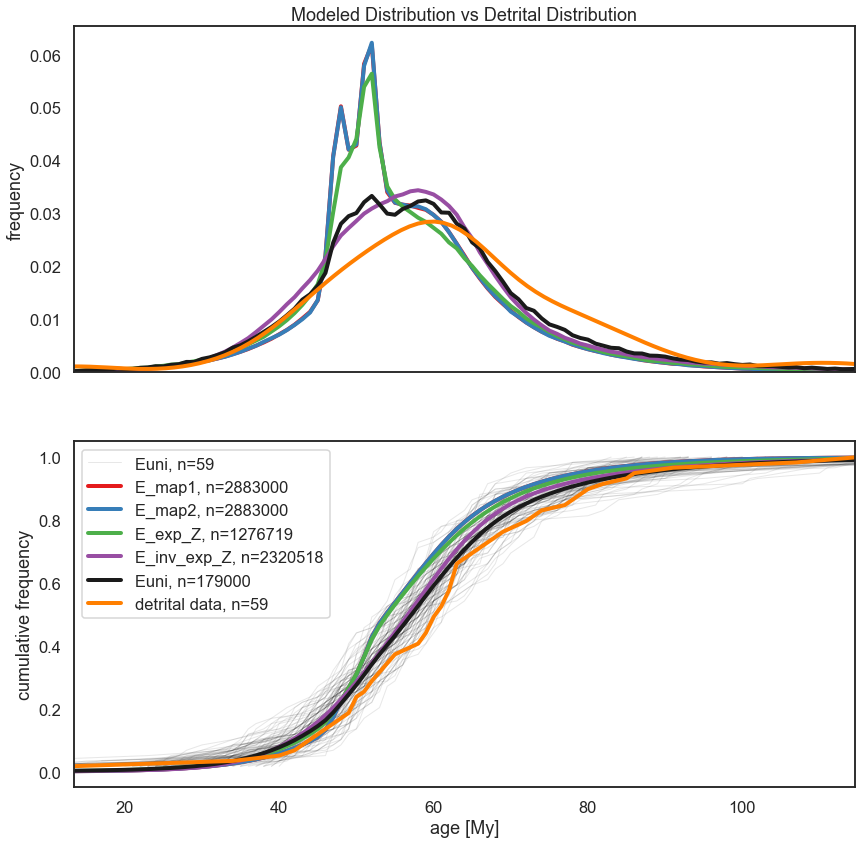

In [44]:
##################################### Plot distributions ################################
#########################################################################################

fig = plt.figure(figsize=(14,14))
gspec = gs.GridSpec(2,1,figure=fig)
ax1 = fig.add_subplot(gspec[0])

# plot all scenarios pdf
color=iter(cm.Set1(np.linspace(0,1,9))) # np.linspace(0,1,len(scen_labels))
for scen,df in dists.items():
    if scen != 'detrital data':
        if scen == 'Euni':
            c='k'
        else:
            c=next(color)
        sns.lineplot(df.vals,df.hist_y,color=c,label='_nolegend_', ax=ax1, lw=4)
        
# plot detrital data pdf
sns.distplot(pops['detrital data'],hist=False,
             kde_kws={'color':next(color),'linewidth':4},label='_nolegend_', ax=ax1)
ax1.set(xlim=(dd.age.min(),dd.age.max()), ylabel='frequency', xlabel='', xticks=[],
        title='Modeled Distribution vs Detrital Distribution')

# second row
ax2 = fig.add_subplot(gspec[1])

# plot all scenarios cdf, including 100 random subsamples of Euni
for i in np.arange(100):
    pop1 = np.random.choice(pops['Euni'],len(dd))
    if i==0:
        dist1 = make_dists(pop1)
        sns.lineplot(dist1.vals,dist1.cdf_y,
                     color='k', alpha=0.1, lw=1, ax=ax2, label='Euni, n='+str(len(dd)))
    else:
        dist1 = make_dists(pop1)
        sns.lineplot(dist1.vals, dist1.cdf_y,
                     color='k', alpha=0.1, lw=1, ax=ax2, label='_nolegend_')

color=iter(cm.Set1(np.linspace(0,1,9))) # np.linspace(0,1,len(scen_labels))
for scen,df in dists.items():
    if scen == 'Euni':
        c='k'
    else:
        c=next(color)
    sns.lineplot(df.vals,df.cdf_y,color=c,label=scen+', n='+str(df.valcount.sum()), ax=ax2, lw=4)

ax2.set(xlim=(dd.age.min(),dd.age.max()), ylabel='cumulative frequency', xlabel='age [My]')
ax2.legend()

# save fig
fig.savefig(opf+'/detrital_distributions.pdf', dpi=200)

## Confidence in discerning between observed detrital distribution and 'Euni' 

In [88]:
def get_KS(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    returns KS statistic
    '''
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)

    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # return KS statistic between real and interpolated from downsampled
    return max(np.abs(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y)-res_d))

def get_KL(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    dist_kind = 'cdf' or 'hist'
    bounds = limits of the distribution, defined at the beginning
    returns characteristic KL divergence at the chosen confidence level
    '''
    from scipy.stats import entropy
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)
    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # return KL divergence between real and interpolated from downsampled
    return entropy(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y), res_d)

# Assign some variables
all_k = np.arange(10,len(dd)+5,5) # possible N of dated grains (k) to consider
k_iter = 1000 # iterations per k value
confint = 68 # % confidence interval to solve for <----------------------------------------!!!!!

ref_scen = 'Euni' # reference erosion scenario
# which statistic to be used? [get_KS, 'KS statistic'] , [get_KL,'KL divergence']  
stat = [get_KL, 'KL divergence']

# calculate 95% confidence divergence for each k, between 'Euni' n=∞ and 'Euni' n=len(dd)
Dc_within = {} # critical divergence between the reference scenario and the subsampled itself
D_dist_dict = {} # store distributions for later confidence plot
Dc = []
for k in all_k:
    # make array of integers (all equal k) with length k_iter
    k_array = (np.ones(k_iter)*k).astype(int)
    # get array of random divergencies, using chosen statistic
    D_arr = np.array([stat[0](np.random.choice(pops[ref_scen],k),dists[ref_scen]) for k in k_array])
    # sort values
    D_arr.sort()
    # calculate cumulative probability of each value
    D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
    D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
    ind95 = np.where(D_arr_prob<=0.95)[0][-1] # index of the 95th percentile
    # store values
    Dc.append(D_arr_vals[ind95])
    D_dist_dict[ref_scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]
Dc_within[ref_scen] = Dc

# calculate divergence for each k, between reference scenario and detrital data
Dc_between = {}  # critical divergence between the reference scenario and another subsampled scenario

# The confidence interval of the analysis is the product confint*0.95
# because it's the probability of two events occurring together:
# Dc_within being smaller than the 95th percentile of the iterations,
# and Dc_between being larger than the 1-confint percentile of the iterations
ci = confint/100/0.95

for scen in scen_labels:
    Dc = []
    for k in all_k:
        # make array of integers (all equal k) with length k_iter
        k_array = np.round(np.ones(k_iter)*k).astype(int)
        # get array of random divergencies, using chosen statistic
        D_arr = np.array([stat[0](np.random.choice(pops[scen],k),dists[ref_scen]) for k in k_array])
        # sort values
        D_arr.sort()
        # calculate cumulative probability of each value
        D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
        D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
        if np.where(D_arr_prob<=1-ci)[0].size < 1:
            print('None of the iterations could discern '+scen+' from '+ref_scen+' with '+
                  str(k)+' grains at '+str(confint)+'% confidence')
            Dc.append(0.0) # divergence between scenarios is formally null 
        else:
            ind_ci = np.where(D_arr_prob<=1-ci)[0][-1] # index of the target confidence level
            # store values
            Dc.append(D_arr_vals[ind_ci])
        D_dist_dict[scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]
    Dc_between[scen] = Dc

################ Calculate the confidence as function of the number of grains ########################
###############################################################################################

# Compare Dc_within to all scenarios for all k
# and get the probability of a scenario being discerned from reference for each k
probs = {}
for scen in scen_labels:
    probs1 = []
    for i in np.arange(len(all_k)): # for all k values
        # get index of element where Dc_within is smaller than Dc_between
        ind = np.where(D_dist_dict[scen+'_'+str(all_k[i])][0]>Dc_within[ref_scen][i])[0][0]
        # get complementary probability of ind,
        # because we're interested in how many values are larger than that (not smaller)
        probs1.append(100*(1-D_dist_dict[scen+'_'+str(all_k[i])][1][ind])) 
    probs[scen] = probs1

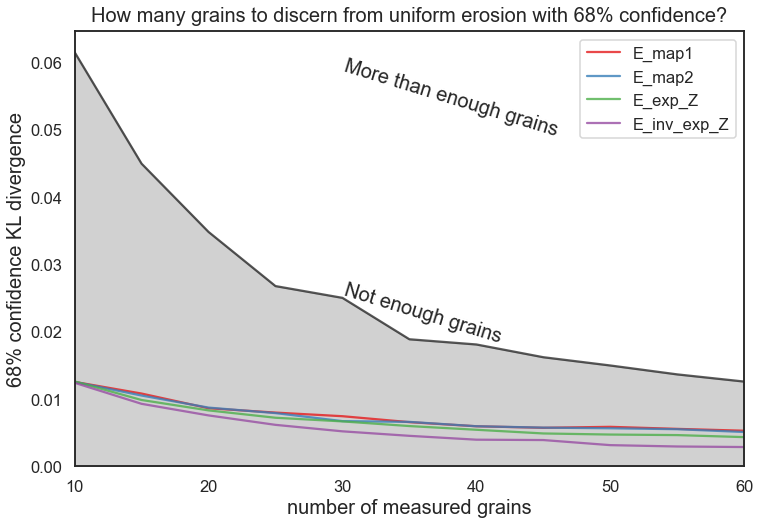

In [89]:
############################## Plot results #################################################
#############################################################################################

def smooth(y, window_size=3, order=1, deriv=0, rate=1):
    '''
    dirty smoothing function, so that curves can be calculated on the base of ~1000 iterations,
    but still look good, if wanted
    '''
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        print("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y1 = np.concatenate((firstvals, y, lastvals))
    y_new = np.convolve( m[::-1], y1, mode='valid')
    y_new[0] = y[0]
    return y_new

def plot_div_analysis(ci, Dw=None, Db=None, ylabel='divergence', ref_scen='Euni', saveas=None):
    '''
    plotting function to compare D_within and D_between
    saveas= string, path and filename with extension .png, .pdf, .eps or .tiff
    '''
    fig,ax = plt.subplots(figsize=(12,8))
    leg = []
    if Dw:
        color=iter(cm.rainbow(np.linspace(0,1,len(scen_labels))))
        for key,D in Dw.items():
            ax.fill_between(all_k, D, color='k', alpha=0.2, label='_nolegend_')
            ax.plot(all_k, D, c='k', alpha=0.7, label='_nolegend_')
    if Db:
        color=iter(cm.Set1(np.linspace(0,1,9)))
        for key,D1 in Db.items():
            c = next(color)
            ax.plot(all_k,D1,c=c, alpha=0.8)
            leg.append(key)
    
    ax.set(ylim=(0,None), xlim=(all_k[0],all_k[-1]))
    ax.set_xlabel('number of measured grains', fontdict=dict(size=20))
    ax.set_ylabel('{}% confidence {}'.format(ci,ylabel), fontdict=dict(size=20))
    ax.set_title('How many grains to discern from uniform erosion with {}% confidence?'.format(ci),
                 fontdict=dict(size=20), pad=10)
    ax.legend(leg, loc=('upper right'))
    ax.text(30,max(D)*0.3,'Not enough grains', fontdict=dict(size=20,rotation=-17))
    ax.text(30,max(D)*0.8,'More than enough grains', fontdict=dict(size=20,rotation=-17))
    
    # save figure
    if saveas is not None:
        fig.savefig(saveas, dpi=200)

plot_div_analysis(ci=confint, Dw=Dc_within, Db=Dc_between, ylabel=stat[1], saveas=None)

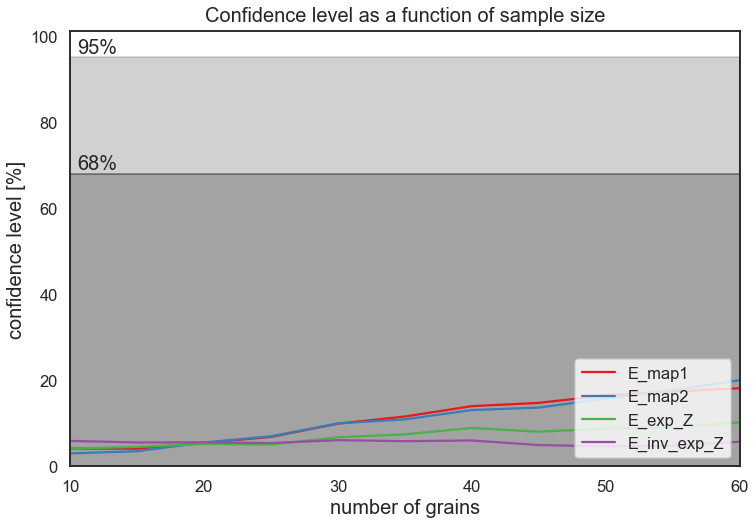

In [90]:
################ Plot the confidence as function of grain number ########################
#########################################################################################

def plot_confidence(prob_dict, all_k):
    '''
    plots the confidence level as function of sample size
    prob_dict: dictionary of arrays, each containing confidence values related to all_k
    all_k: 1D-array of k values (integers)
    '''
    fig,ax = plt.subplots(figsize=(12,8))
    # plot grey fields
    ax.fill_between([all_k[0],all_k[-1]],[95,95],[68,68],color='k',alpha=0.2)
    ax.text(all_k[0]+0.5,96,'95%',fontdict=dict(size=20))
    ax.fill_between([all_k[0],all_k[-1]],[68,68],color='k',alpha=0.4)
    ax.text(all_k[0]+0.5,69,'68%',fontdict=dict(size=20))
    color=iter(cm.Set1(np.linspace(0,1,9)))
    leg=[]
    for key,i in prob_dict.items():
        c = next(color)
        ax.plot(all_k,
                smooth(i),
                c=c,
                alpha=1)
        leg.append(key)
    ax.set(xlim=(all_k[0],all_k[-1]), ylim=(0,101), yticks=[0,20,40,60,80,100])
    ax.set_xlabel('number of grains',fontdict=dict(size=20))
    ax.set_ylabel('confidence level [%]',fontdict=dict(size=20))
    ax.set_title('Confidence level as a function of sample size', fontdict=dict(size=20), pad=10)
    ax.legend(leg, loc='lower right')
    
plot_confidence(prob_dict=probs, all_k=all_k)

## How does the fit to different scenarios compare?

[Text(0.5, 1.0, 'divergence from detrital data')]

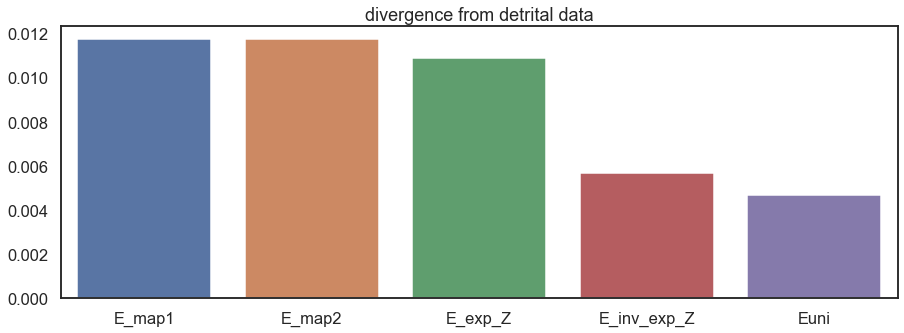

In [92]:
def get_Pdiff(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    returns characteristic Pdiff, modified after Brewer et al. (2003)
    '''
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)
    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # sum(np.abs(res_d-np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y))/res_d*100)/len(d.vals)
    return sum(np.abs(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y)-res_d))/2

ks = []
kl = []
p = []
for scen in scen_labels+[ref_scen]:
    ks.append(get_KS(dd.age, dists[scen]))
    kl.append(get_KL(dd.age, dists[scen]))
    p.append(get_Pdiff(dd.age, dists[scen]))
ks = np.array(ks)
kl = np.array(kl)
p = np.array(p)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
# sns.barplot(x=np.array(scen_labels+[ref_scen]),y=ks, ax=ax)
sns.barplot(x=np.array(scen_labels+[ref_scen]),y=kl, ax=ax)
# sns.barplot(x=np.array(scen_labels+[ref_scen]),y=p, ax=ax)
ax.set(title='divergence from detrital data')


## 3D Plotting example

<IPython.core.display.Javascript object>


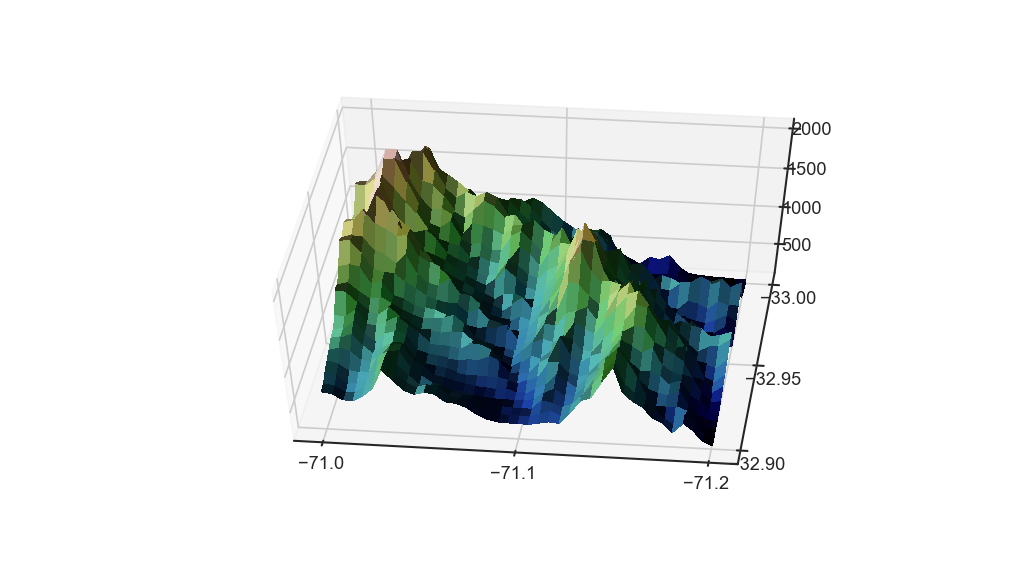

In [38]:
# from matplotlib.colors import LightSource

# %matplotlib notebook

# # Set up plot
# fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,5))

# ls = LightSource(80,20)
# # To use a custom hillshading mode, override the built-in shading and pass
# # in the rgb colors of the shaded surface calculated from "shade".
# rgb = ls.shade(zi_res, cmap=cm.gist_earth,vert_exag=0.3,
#                blend_mode='soft',vmax=2200)
# surf = ax.plot_surface(xi_res84,yi_res84[::-1],zi_res,facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=True)
# ax.set(xticks=[-71.2,-71.1,-71],yticks=[-33,-32.95,-32.9],zticks=[500,1000,1500,2000])
# ax.view_init(70, 115) #50,195